# Continue exploring Tanzina data set

### Load dataset 

In [1]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

LOCAL = '../data/tanzania/'
WEB = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Tree-Ensembles/master/data/tanzania/'
source = LOCAL

train = pd.merge(pd.read_csv(source + 'train_features.csv'), 
                 pd.read_csv(source + 'train_labels.csv'))
test = pd.read_csv(source + 'test_features.csv')
sample_submission = pd.read_csv(source + 'sample_submission.csv')

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

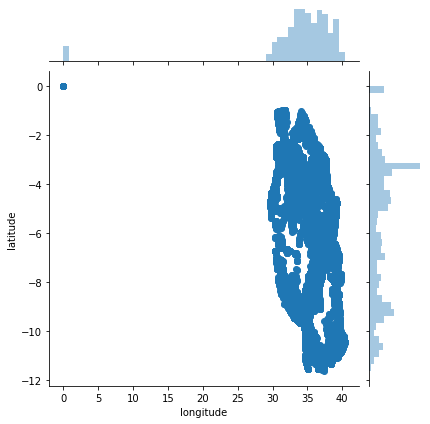

In [2]:
sns.jointplot(x='longitude', y='latitude', data=train);

### Clean issue of null island using mean of the region of the pump

In [3]:
null_island = train[train['longitude'] == 0]
null_island['region'].value_counts()

Shinyanga    793
Mwanza       649
Name: region, dtype: int64

In [4]:
zero_construct_yr = train[train['construction_year'] == 0]
zero_construct_yr['region'].unique()

array(['Mbeya', 'Kagera', 'Dodoma', 'Mwanza', 'Shinyanga', 'Tabora',
       'Arusha', 'Iringa', 'Mtwara', 'Lindi', 'Kilimanjaro', 'Tanga',
       'Pwani', 'Kigoma', 'Ruvuma', 'Singida', 'Mara', 'Morogoro',
       'Dar es Salaam', 'Manyara', 'Rukwa'], dtype=object)

In [5]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace them with the column mean.
    cols_with_zeros = ['construction_year', 'longitude', 'latitude']
    
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col] = X[col].fillna(X[col].mean())
        
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract year from date_recorded
    X['year_recorded'] = X['date_recorded'].dt.year
    
    # quantity & quantity_group are duplicates, so drop one
    X = X.drop(columns='quantity_group')
    
    # for categoricals with missing values, fill with the category 'MISSING'
    categoricals = X.select_dtypes(exclude='number').columns
    for col in categoricals:
        X[col] = X[col].fillna('MISSING')
    
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

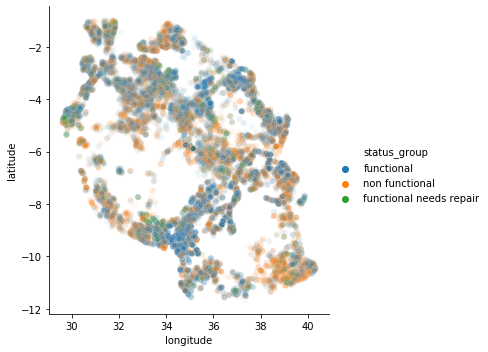

In [6]:
sns.relplot(x='longitude', y='latitude', hue='status_group', 
            data=train, alpha=0.05);

In [7]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[
    target, 
    'id', 
    'date_recorded', 
    'region_code',
    'waterpoint_type_group',
    'source_class',
    'recorded_by',
    'management_group',
    'source_type',
    'quality_group',
    'payment_type',
    'extraction_type_group',
    'extraction_type_class',
    'lga',
    'wpt_name',
    'scheme_name',
    'subvillage'
])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 21].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [8]:
cardinality.sort_values(ascending=False)

ward                 2082
installer            1930
funder               1717
region                 21
extraction_type        18
scheme_management      13
management             12
source                 10
basin                   9
water_quality           8
waterpoint_type         7
payment                 7
quantity                5
permit                  3
public_meeting          3
dtype: int64

In [9]:
from sklearn.tree import DecisionTreeClassifier

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Encoder: fit_transform on train, transform on val & test
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaler: fit_transform on train, transform on val & test
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


# Model: Fit on train, score on val, predict on test
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
print('Train Accuracy', dt.score(X_train_scaled, y_train))
print('Validation Accuracy', dt.score(X_val_scaled, y_val))
# y_pred = dt.predict(X_test_scaled)

Train Accuracy 0.9959595959595959
Validation Accuracy 0.7506734006734007


In [10]:
dt = DecisionTreeClassifier(random_state=42, max_depth=20)
dt.fit(X_train_scaled, y_train)
print(dt.score(X_train_scaled, y_train), dt.score(X_val_scaled, y_val))
y_pred = dt.predict(X_test_scaled)

0.9043560606060606 0.7664983164983165


In [11]:
# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('dt_submission.csv', index=False)

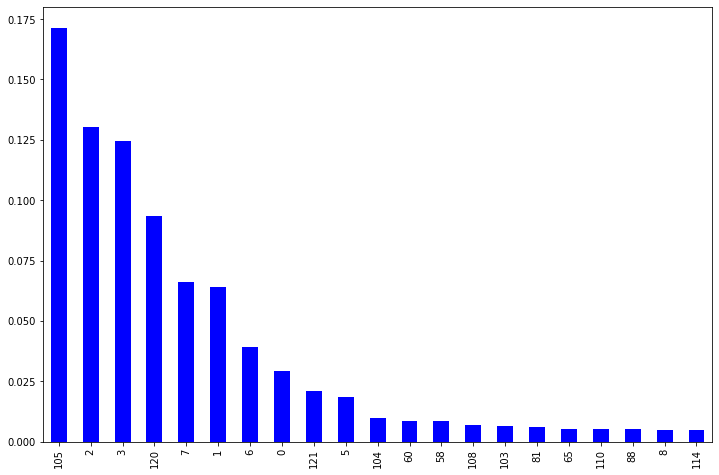

In [12]:
plt.figure(figsize=(12,8))
importances = pd.Series(dt.feature_importances_).sort_values(ascending=False)
importances[:21].sort_values(ascending=False).plot.bar(color='b');

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

print('Train score: ', rf.score(X_train_scaled, y_train))
print('Val score: ', rf.score(X_val_scaled, y_val))

Train score:  0.9959595959595959
Val score:  0.8074074074074075


In [31]:
param_grid = {
    'min_samples_split': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'accuracy_score': make_scorer(accuracy_score)
}

In [32]:
def grid_search_wrapper(refit_score='accuracy_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(rf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_val_scaled)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    # print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    # print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 # columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [33]:
grid_search_rf = grid_search_wrapper(refit_score='accuracy_score')

Best params for accuracy_score
{'max_depth': 25, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 300}


In [14]:
import math
n_feat = (len(features))
n_feat = int(n_feat)
n_feat

21

In [15]:
rf = RandomForestClassifier(max_depth = 50,
                            min_samples_split= 3,
                            max_features= n_feat,
                            n_estimators=500,
                            n_jobs=-1)
rf.fit(X_train_scaled, y_train)

print('Train score: ', rf.score(X_train_scaled, y_train))
print('Val score: ', rf.score(X_val_scaled, y_val))

y_pred = dt.predict(X_test_scaled)

Train score:  0.9925715488215489
Val score:  0.80993265993266


In [140]:
# Write submission csv file
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('rf_submission.csv', index=False)

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=15, learning_rate=0.1, n_estimators=300)
gb.fit(X_train_encoded, y_train)

print('Train score: ', gb.score(X_train_encoded, y_train))
print('Val score: ', gb.score(X_val_encoded, y_val))

Train score:  0.9751262626262627
Val score:  0.805976430976431


In [19]:
# max_depth: 6 , learning: 0.1, n_est: 300
print('Train score: ', gb.score(X_train_encoded, y_train))
print('Val score: ', gb.score(X_val_encoded, y_val))

Train score:  0.859553872053872
Val score:  0.7971380471380471


In [22]:
# max_depth: 10 , learning: 0.1, n_est: 300
print('Train score: ', gb.score(X_train_encoded, y_train))
print('Val score: ', gb.score(X_val_encoded, y_val))

Train score:  0.9751262626262627
Val score:  0.805976430976431
